In [1]:
import os
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
class image_data_set(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, index):
        return {'data': self.data[index], 'label': self.labels[index]}

In [3]:
def get_image_tensor(file_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    image = Image.open(file_path)
    return transform(image)
    
def get_data_sets(downloaded_data_dir, json_file_name): 
    json_file = open(downloaded_data_dir + json_file_name)
    coco_key = json.load(json_file)
    images = coco_key["images"]

    data, labels = [], []
    for index, image in enumerate(images):
        file_name = image["file_name"]
        file_path = downloaded_data_dir + file_name
        
        if os.path.isfile(file_path):
            label = coco_key["annotations"][index]["category_id"]
            try:
                image_tensor = get_image_tensor(file_path)
                data.append(image_tensor)
                labels.append(label)
            except:
                print("Truncated image encountered, leaving out of training and testing")
    
    training_data, testing_data, training_labels, testing_labels = train_test_split(data, labels, test_size = 0.005)
    
    print("\nNumber of training photos: " + str(len(training_data)))
    print("Number of testing photos: " + str(len(testing_data)))
    
    json_file.close()
    
    return training_data, testing_data, training_labels, testing_labels

In [4]:
def print_image(image_tensor, prediction, downloaded_data_dir, index):
    if(prediction == 1):
        prediction_string = "Wildlife_Present"
    else:
        prediction_string = "No_Wildlife_Present"

    image_file_name = downloaded_data_dir + prediction_string + "_" + str(index) + ".png"
    
    #Alternative normalized RGB visualization: plt.imshow(image_tensor.cpu().permute(1, 2, 0).numpy())
    plt.imshow(image_tensor[0].cpu(), cmap="gray")
    plt.title("Incorrectly Predicted " + prediction_string) 
    plt.show()
    plt.imsave(image_file_name, image_tensor[0].cpu(), cmap="gray")

def print_testing_analysis(all_labels, all_predictions, title, downloaded_data_dir):
    subplot = plt.subplot()

    cf_matrix = confusion_matrix(all_labels, all_predictions, labels=[1, 0])
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

    subplot.set_xlabel('Predictions')
    subplot.set_ylabel('Labels')
    subplot.set_title(title + ' Testing Confusion Matrix')
    subplot.xaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    subplot.yaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    
    plot_file_name = downloaded_data_dir + title + "_Confusion_Matrix.png"
    plt.savefig(plot_file_name)
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    print(title + " Accuracy: " + str(accuracy))

    precision, recall, f_score, support = precision_recall_fscore_support(all_labels, all_predictions)
    print(title + " Precision: " + str(precision))
    print(title + " Recall: " + str(recall))
    print(title + " F-Score: " + str(f_score))

def train(model, training_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(training_loader):
        data, labels = data['data'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        num_correct += (predictions == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    loss = running_loss/len(training_loader.dataset)
    accuracy = num_correct/len(training_loader.dataset)
    return loss, accuracy

def test(model, testing_loader, criterion, print_incorrect_images, downloaded_data_dir):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    all_labels, all_predictions = [], []

    for i, data in enumerate(testing_loader):
        data, labels = data['data'].to(device), data['label'].to(device)
        output = model(data)
        
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        for index, prediction in enumerate(predictions):
            if(prediction == labels[index]):
                num_correct += 1
            elif(print_incorrect_images):
                print_image(data[index], prediction, downloaded_data_dir, i)

        all_labels.extend(labels.cpu())
        all_predictions.extend(predictions.cpu())
    
    loss = running_loss/len(testing_loader.dataset)
    accuracy = num_correct/len(testing_loader.dataset)
    return loss, accuracy, all_labels, all_predictions

In [5]:
def train_and_test_models(resnet50, resnet152, vit_l_16, training_loader, testing_loader, device, criterion, downloaded_data_dir):
    print("\nTraining and Testing ResNet50")
    train_and_test(resnet50, training_loader, testing_loader, device, criterion, downloaded_data_dir)

    print("\nTraining and Testing ResNet152")
    train_and_test(resnet152, training_loader, testing_loader, device, criterion, downloaded_data_dir)

    print("\nTraining and Testing ViT Large 16")
    train_and_test(vit_l_16, training_loader, testing_loader, device, criterion, downloaded_data_dir)

def train_and_test(model, training_loader, testing_loader, device, criterion, downloaded_data_dir):    
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
        
    training_loss, training_accuracy = train(model, training_loader, criterion, optimizer)
    print("training loss: " + str(training_loss) + " and training accuracy: " + str(training_accuracy))
        
    testing_loss, testing_accuracy, _, _ = test(model, testing_loader, criterion, False, downloaded_data_dir)
    print("testing loss: " + str(testing_loss) + " and testing accuracy: " + str(testing_accuracy))

# Declaring Constants

In [6]:
num_epochs = 1
num_classes = 10
batch_size = 20
json_file_name = "oregon_number_detection.json"
downloaded_data_dir = "number_detection_manually_labeled_wildlife_data/"

print(torch.__version__)
print(torchvision.__version__)
print("torch.cuda.is_available(): " + str(torch.cuda.is_available()))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
criterion = nn.CrossEntropyLoss()

1.12.1
0.13.1
torch.cuda.is_available(): False


# Loading Data

In [7]:
training_data, testing_data, training_labels, testing_labels = get_data_sets(downloaded_data_dir, json_file_name)
training_data_set = image_data_set(training_data, training_labels)
testing_data_set = image_data_set(testing_data, testing_labels)
training_loader = DataLoader(dataset = training_data_set, batch_size = batch_size, shuffle = True)
testing_loader = DataLoader(dataset = testing_data_set, batch_size = batch_size, shuffle = True)


Number of training photos: 13
Number of testing photos: 1


# Declaring Models

In [8]:
resnet50 = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
resnet50.fc.out_features = num_classes

resnet152 = models.resnet152(weights = models.ResNet152_Weights.DEFAULT)
resnet152.fc.out_features = num_classes

vit_l_16 = models.vit_l_16(weights = models.ViT_L_16_Weights.DEFAULT)
vit_l_16.heads.out_features = num_classes

if torch.cuda.device_count() > 1:
    print("Multiple GPUs available, using: " + str(torch.cuda.device_count()))
    resnet50 = nn.DataParallel(resnet50)
    resnet152 = nn.DataParallel(resnet152)
    vit_l_16 = nn.DataParallel(vit_l_16)

# Training

In [9]:
all_testing_data, all_testing_labels = [], []

for epoch in range(num_epochs):
    print("Epoch: " + str(epoch))
    train_and_test_models(resnet50, resnet152, vit_l_16, training_loader, testing_loader, device, criterion, downloaded_data_dir)

Epoch: 0

Training and Testing ResNet50
training loss: 0.523830193739671 and training accuracy: 0.0
testing loss: 6.624418258666992 and testing accuracy: 0.0

Training and Testing ResNet152
training loss: 0.5390938612130972 and training accuracy: 0.0
testing loss: 5.9012908935546875 and testing accuracy: 0.0

Training and Testing ViT Large 16
training loss: 0.5976419815650353 and training accuracy: 0.0
testing loss: 3.4328343868255615 and testing accuracy: 1.0


# Final Testing

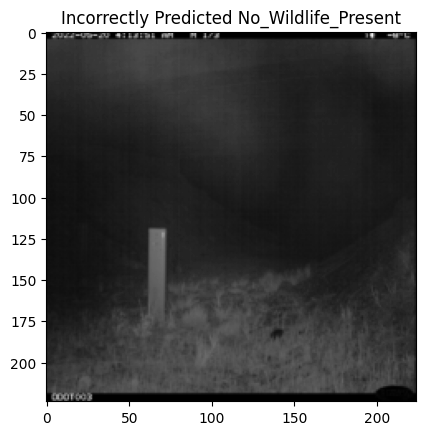

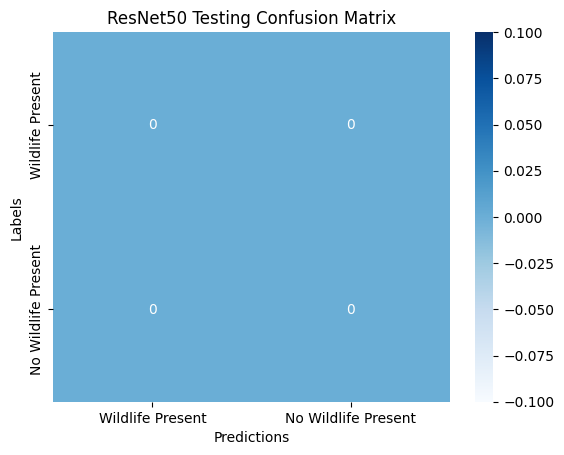

ResNet50 Accuracy: 0.0
ResNet50 Precision: [0. 0.]
ResNet50 Recall: [0. 0.]
ResNet50 F-Score: [0. 0.]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


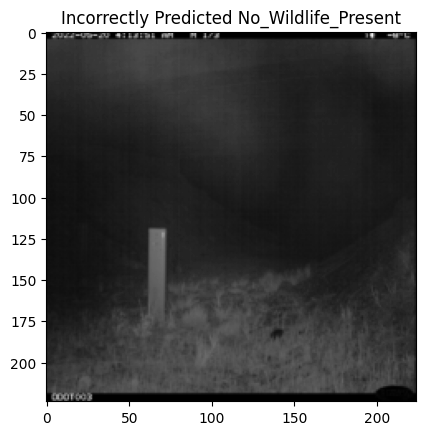

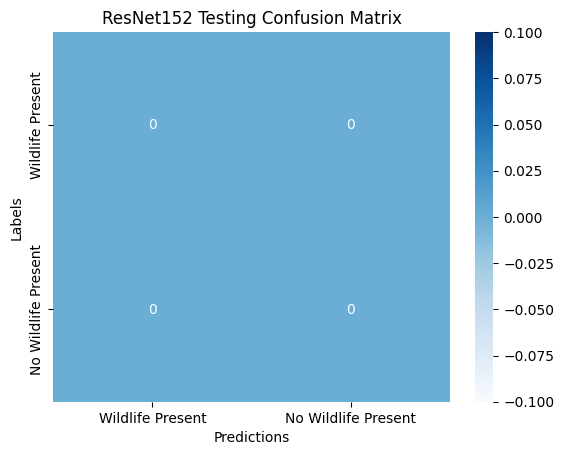

ResNet152 Accuracy: 0.0
ResNet152 Precision: [0. 0.]
ResNet152 Recall: [0. 0.]
ResNet152 F-Score: [0. 0.]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


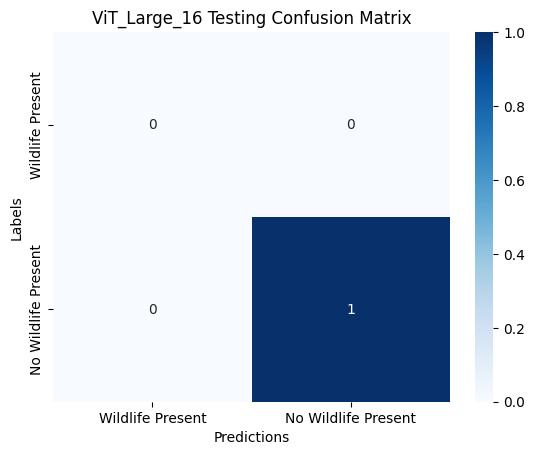

ViT_Large_16 Accuracy: 1.0
ViT_Large_16 Precision: [1.]
ViT_Large_16 Recall: [1.]
ViT_Large_16 F-Score: [1.]


In [10]:
testing_loss, testing_accuracy, labels, predictions = test(resnet50, testing_loader, criterion, True, downloaded_data_dir)
print_testing_analysis(labels, predictions, "ResNet50", downloaded_data_dir)

testing_loss, testing_accuracy, labels, predictions = test(resnet152, testing_loader, criterion, True, downloaded_data_dir)
print_testing_analysis(labels, predictions, "ResNet152", downloaded_data_dir)

testing_loss, testing_accuracy, labels, predictions = test(vit_l_16, testing_loader, criterion, True, downloaded_data_dir)
print_testing_analysis(labels, predictions, "ViT_Large_16", downloaded_data_dir)